# RAG chatbot using Amazon Bedrock and LangChain

## Overview

Chatbots are one of the most prominent and common GenAI use cases. These applications can have long running and stateful conversation. These applications can provide answer to user questions using source information. These Chatbots commonly use RAG to fetch relevant information from domain data. By leveraging RAG, Q&A chatbots can offer more precise, up-to-date, and context-aware answers than traditional chatbots or standalone LLMs.

User can have back and forth conversation with these applications that's why memory is required of past question and answer. 

In this sample you will learn how to build RAG based chatbot using Amazon Bedrock and LangChain. We will cover following concepts 

• This notebook covers the basic components of building a Q&A chatbot using Amazon Bedrock and LangChain.

• Incorporate historical messages to build context aware conversation

• Memory management 



## Architecture

Below is a high-level overview of RAG architecture. 

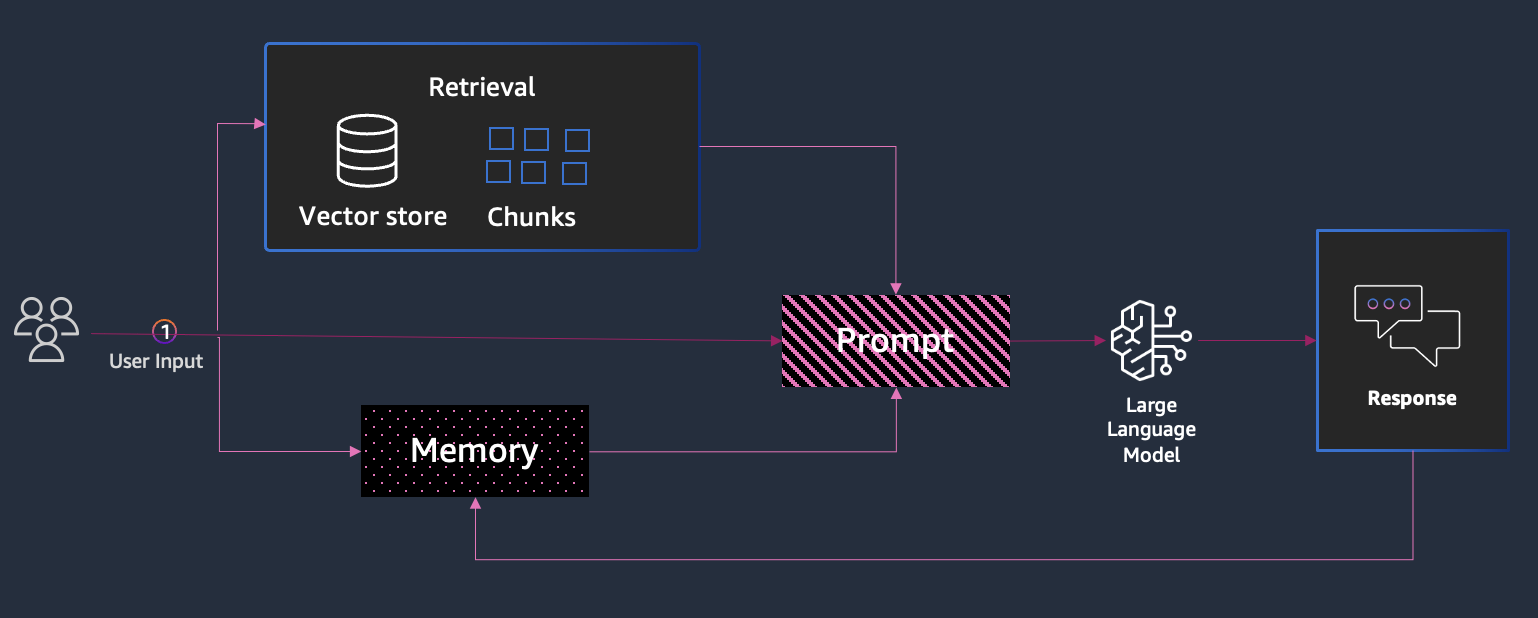

We have three high level scenarios: 

- Send user input to LLM and get the response back
- Retrieve relevant information from domain data using RAG, augment the prompt with additional context and send it to LLM for response
- Use historical messages along with user input to build context aware conversation

### Dependencies

We’ll use Anthropic's Claude 3 Sonnet model from Amazon Bedrock as generation model, Amazon Titan embedding as embeddings and a Chroma vector store in this walkthrough. We will use LangChain as an orchestrator to build this Q&A chatbot. 
We will also use LangSmith for tracing and debugging. 



In [17]:
%pip install --upgrade --quiet  langchain langchain-community langchain_aws langchain-chroma langchainhub beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


## Setup

**Let's first test the basic setup with Amazon Bedrock.**

In [5]:
from langchain_aws import ChatBedrockConverse
import boto3
# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

model = ChatBedrockConverse(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
)

Now that we have verified basic setup, let's move on to the next step - building Q&A chatbot.

In [6]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

**Following step is optional**

In [ ]:
# this is required if you want to enable tracing using LangSmith
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Bedrock Q&A chatbot"

## 1. Basic Chatbot using Bedrock and LangChain

Let's look at the first scenario of building basic chatbot using Amazon Bedrock and LangChain. We will not use external data source for this example. 

`ChatModels` are instances of LangChain "Runnables", which means they expose a standard interface for interacting with them. To just simply call the model, we can pass in a list of messages to the `.invoke` method.

In [6]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi! I'm Bob")])

AIMessage(content="Hi Bob, nice to meet you! I'm Claude, an AI assistant created by Anthropic. How are you doing today?", response_metadata={'ResponseMetadata': {'RequestId': '78452ca6-8bb8-4982-9aea-d664c86c7ea0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sat, 24 Aug 2024 11:02:58 GMT', 'content-type': 'application/json', 'content-length': '281', 'connection': 'keep-alive', 'x-amzn-requestid': '78452ca6-8bb8-4982-9aea-d664c86c7ea0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': 978}}, id='run-0fc8bc2b-e3fa-4e97-bc9b-e175621895bd-0', usage_metadata={'input_tokens': 12, 'output_tokens': 30, 'total_tokens': 42})

We have a basic chatbot! 

In real world, we would be using more information and instructions from user. We need to pass all this information to the model in a format that it can understand. For this we need to look into Prompt Templates. 


### Prompt Templates

Prompt Templates help to turn raw user information into a format that the LLM can work with. 

First, let's add in a system message with some custom instructions (but still taking messages as input). Next, we'll add in more input besides just the messages.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

chain = prompt | model

In [8]:
response = chain.invoke({"messages": [HumanMessage(content="hi! I'm bob")]})

response.content

"Hi Bob, it's nice to meet you! I'm an AI assistant created by Anthropic. How can I help you today?"

## 2. Chatbot with Conversation History

In the previous example, we were only passing in a single message at a time. Model does not have any idea of the previous message. 
But what if we want to pass in multiple messages? We can do that by using Message History.

We can use a Message History class to wrap our model and make it stateful. This will keep track of inputs and outputs of the model, and store them in some datastore. Future interactions will then load those messages and pass them into the chain as part of the input. Let's see how to use this!

We can retrieve message history using the `session_id` and then use `RunnableWithMessageHistory` class to invoke model with message history.

In [9]:
from langchain_core.chat_history import (
    BaseChatMessageHistory,
    InMemoryChatMessageHistory,
)
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(model, get_session_history)

In [10]:
config = {"configurable": {"session_id": "abc2"}}

In [11]:
response = with_message_history.invoke(
    [HumanMessage(content="Hi! I'm Bob")],
    config=config,
)

response.content

"Hello Bob, nice to meet you! I'm Claude, an AI assistant created by Anthropic. How are you doing today?"

In [12]:
response = with_message_history.invoke(
    [HumanMessage(content="What's my name?")],
    config=config,
)

response.content

'You said your name is Bob when you introduced yourself.'

You can notice in above response that model is able to tell the name based on previous message.  

Now let's see how we can use prompt template with message history. We can use `chain` with th `RunnableWithMessageHistory` to invoke model with prompt template.

In [14]:
with_message_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key="messages",
)

In [13]:
config = {"configurable": {"session_id": "abc2"}}

In [16]:
response = with_message_history.invoke(
    {'messages': [HumanMessage(content="Hi! I'm Bob")]},
    config=config,
)

response.content

'Hello Bob!'

## 3. Conversational RAG

So far we have seen how we can create a basic chatbot with LangChain using LLM from Amazon Bedrock. But what if we want to build a chatbot that uses domain data to answer questions? 

We can use Retriever to pull the data from the knowledge base and Answerer to answer the questions. We can also use PromptTemplate to customize the prompt for retrieval and question answering.


Let's first get the data, get the vector embeddings from the model and store them in a vector store. Lets use bedrock documentation as a data source.

In [9]:
from langchain.document_loaders import PyPDFLoader
import os
from urllib.request import urlretrieve

url = "https://docs.aws.amazon.com/pdfs/bedrock/latest/studio-ug/bedrock-studio-user-guide.pdf"
file_path = "bedrock-studio-user-guide.pdf"
urlretrieve(url, file_path)


loader = PyPDFLoader("bedrock-studio-user-guide.pdf")
data = loader.load()

Let's split the documents into chunks and create a vector store using Chroma vector store

In [4]:
from langchain_chroma import Chroma
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings_model = BedrockEmbeddings(
    bedrock_client, model_id="amazon.titan-embed-text-v1"
)


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(data)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings_model)
retriever = vectorstore.as_retriever()

The key components are: retriever, LLM for generation and prompt template. We are first  creating `create_stuff_documents_chain` using LLM and prompt. Then en we create a retrieval chain using `create_retrieval_chain` to combine the two chains. 

Our retriever should retrieve information relevant to the last message we pass in from the user, so we extract it and use that as input to fetch relevant docs, which we add to the current chain as context. We pass context plus the previous messages into our document chain to generate a final answer.

In [7]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [8]:
response = rag_chain.invoke({"input": "What is Bedrock studio"})
response["answer"]

'Amazon Bedrock Studio is a web application that allows you to easily prototype and build apps that use Amazon Bedrock\'s large language models and features, without needing to set up a developer environment or write code. It provides two main modes:\n\n1. Explore mode - This is a playground where you can experiment with an Amazon Bedrock model by sending prompts and viewing the responses, to get a feel for the model\'s capabilities.\n\n2. Build mode - This mode allows you to create prototype apps that integrate Amazon Bedrock models and features like knowledge bases or guardrails. You can build chat apps or "Prompt Flows" apps using a visual interface without writing code.\n\nAmazon Bedrock Studio requires you to be a member of a workspace set up by your organization. Your organization\'s administrator provides you with login details to access the studio environment within their workspace. If you don\'t have login details, you\'ll need to contact your administrator.'

Now our chatbot can answer questions based on the provided document. 

## Contextualizing questions

The above chain works well for retrieval-based question-answering, but it's not very good at understanding the context of the second question.

If my next question is 

> How can I set it up? 

LLM will not be able to understand 

> it

In order to fix this issue we need to update the prompt and a new chain to that takes the latest user question and reformulates it in the context of the chat history. 

In [10]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    model, retriever, contextualize_q_prompt
)

Now we just need to add chat history in the prompt and use `history_aware_retriever` in the previous code snippet. 

In [11]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(model, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

Let's see how the full example works with the history

In [12]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Bedrock studio?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "How can I set it up?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

The provided context does not give specific details on how to set up Amazon Bedrock Studio yourself. However, it mentions that to use Bedrock Studio, you must be a member of a workspace set up by your organization, and you need to get login details from your organization's administrator.

Specifically, the context states:

"To use Amazon Bedrock Studio, you must be a member of a workspace. Your organization will provide you with login details. If you don't have login details, contact your administrator."

And:

"To get started with Amazon Bedrock Studio, you need an email invitation to an Amazon Bedrock Studio workspace. If you haven't received the invitation email from your organization, contact your organization's administrator."

So based on the information provided, you cannot set up Bedrock Studio on your own. The setup and provisioning of workspaces seems to be handled by your organization's IT administrators. As an end-user, you need to reach out to your admin and get invited/ad

As we have seen in above example in real world applications we need some way of persisting chat history. For this we can use 

`BaseChatMessageHistory` class to store chat history and 
`RunnableWithMessageHistory`: to handle injecting chat history into inputs and updating it after each invocation

In [15]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [16]:
conversational_rag_chain.invoke(
    {"input": "What is Bedrock studio?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

'Based on the provided context, Amazon Bedrock Studio is a web application that allows users to easily prototype and build applications that utilize Amazon Bedrock models and features, without needing to set up a developer environment or write code. Some key points about Bedrock Studio:\n\n1) It lets you experiment with Amazon Bedrock models by sending prompts and viewing responses in an "Explore" mode playground.\n\n2) You can then use the "Build" mode to create prototype chat applications or "Prompt Flows" applications that incorporate Amazon Bedrock models and capabilities like knowledge bases or guardrails.\n\n3) To access Bedrock Studio, you need to be a member of a workspace, which your organization will provide login details for.\n\nIn summary, Bedrock Studio is a no-code tool that enables easy prototyping and building of applications powered by Amazon\'s large language models and AI services under the Bedrock umbrella.'

In [17]:
conversational_rag_chain.invoke(
    {"input": "How to build a chat app with it"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'According to the provided context, here are the steps to build a chat app with Amazon Bedrock Studio:\n\n1. Open your Amazon Bedrock Studio workspace and go to the "Build" mode.\n\n2. If it\'s your first time, Bedrock Studio will create a default project and an empty chat app within it.\n\n3. In the "Configs" pane, select the Amazon Bedrock model you want your app to use.\n\n4. Give your app a name, e.g. "Radio show" in the example.\n\n5. Enter a "System prompt & examples" to set the initial prompt and examples for the model.\n\n6. You can add additional components like guardrails, data sources, and function calls to enhance your app\'s capabilities.\n\n7. Share your project with team members if you want to collaborate.\n\nThe key steps are selecting the Bedrock model, providing an initial prompt/examples, and optionally adding components like guardrails or data integrations. Bedrock Studio\'s Build mode provides a low-code environment to prototype conversational AI apps powered by Am

## Conclusion

In this notebook, we explored how to build a question-answering chatbot using Amazon Bedrock and LangChain. We started with a basic chatbot that responds based on the current user input without any context. Then, we incorporated conversation history to enable context-aware responses.

Next, we leveraged the Retrieval Augmented Generation (RAG) approach to fetch relevant information from a domain-specific document and augment the prompt with this context before generating a response. We also learned how to contextualize follow-up questions based on the conversation history to improve the relevance of retrieved information.

## Next steps

Now that we have covered basic implementation of a chatbot using Amazon Bedrock, you can dive deep into following topics:

- How to manage large message history
- Streaming responses
- Different types of retrievers and retrieval strategies